# imports

In [82]:
from __future__ import division

In [103]:
%matplotlib notebook
import matplotlib.pyplot as plt
from schlichtanders.mymatplotlib import Centre
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn
# plt.style.use('ggplot')

In [2]:
import os, platform, sys
from pprint import pprint

In [3]:
__file__ = os.path.realpath('__file__')
if platform.system() == "Windows":
    from schlichtanders.myos import replace_unc
    __file__ = replace_unc(__file__)
__path__ = os.path.dirname(__file__)
__parent__ = os.path.dirname(__path__)

In [4]:
from sqlalchemy import Column, Integer, Unicode, UnicodeText, String, PickleType, Float, Boolean
from sqlalchemy import create_engine, MetaData, Table
from sqlalchemy.orm import sessionmaker, Session, create_session
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.ext.automap import automap_base
import operator as op
from collections import defaultdict
import csv
import heapq
from copy import copy
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
inf = float('inf')

In [5]:
import experiment_toy_models
import experiment_util
from schlichtanders.mycontextmanagers import ignored
from schlichtanders.myobjects import Namespace
from evaluation import get_modes
import evaluation as eva

gnumpy: failed to import cudamat. Using npmat instead. No GPU will be used.


In [6]:
import numpy as np
import theano

In [7]:
model_names = { # sorted by optimization type
    "ml": ['baselinedet'],
    "annealing": ['baseline', 'mixture', 'planarflow', 'planarflowdet', 'radialflow', 'radialflowdet'],
}
model_prefixes = reduce(op.add, model_names.values())

In [8]:
_model_prefixes = [p+"_" for p in model_prefixes]

# Hyperparameters
# ===============

Base = declarative_base()

class Hyper(Base):
    __tablename__ = "hyper"
    id = Column(Integer, primary_key=True)

    # hyper parameters:
    x_true = Column(Float)
    dim = Column(Integer)
    max_epochs_without_improvement = Column(Integer)
    logP_average_n = Column(Integer)
    errorrate_average_n = Column(Integer)
    minus_log_s1 = Column(Integer)
    minus_log_s2 = Column(Integer)
    batch_size = Column(Integer)

    n_normflows = Column(Integer)

    opt_identifier = Column(String)
    opt_momentum = Column(Float)
    opt_offset = Column(Float)
    opt_decay = Column(Float)
    opt_step_rate = Column(Float)

    for _prefix in _model_prefixes:
        exec("""
{0}best_val_loss = Column(Float)
{0}best_parameters = Column(PickleType, nullable=True)
{0}train_loss = Column(PickleType)
{0}val_loss = Column(PickleType)
{0}epochs = Column(Integer)
{0}init_params = Column(PickleType, nullable=True)
{0}val_error_rate = Column(Float)""".format(_prefix))
    def __init__(self, x_true, dim):
        """
        Parameters
        ----------
        datasetname : str
        """
        self.x_true = x_true
        self.dim = dim
        self.max_epochs_without_improvement = 30
        self.logP_average_n = 3  # TODO random.choice([1,10])
        self.errorrate_average_n = 10
        self.init_results()

    def init_results(self):

        # extra for being able to reset results for loaded hyperparameters
        for prefix in _model_prefixes:
            setattr(self, prefix + "best_parameters", None)
            setattr(self, prefix + "best_val_loss", inf)
            setattr(self, prefix + "train_loss", [])
            setattr(self, prefix + "val_loss", [])
            setattr(self, prefix + "best_epoch", 0)
            setattr(self, prefix + "init_params", None)
            setattr(self, prefix + "val_error_rate", inf)
            
    def __repr__(self):
        return "hyper %i" % hash(self)

            

# Collect models and find best ones

In [9]:
n_best = 2
best_hyper = eva.get_best_hyper(["toy2d"], Hyper, model_prefixes,
                                n_best=n_best, test_suffix=["best_val_loss"])

In [10]:
best_hyper['best_val_loss']['baseline'][1]

([-2.0124658341376818, -2.0109226339991473],
 [hyper 8780840787481, hyper 8780840781629])

# Compute Results on Test-set

In [124]:
from sklearn import cross_validation

In [125]:
dim=2
error_func = experiment_util.RMSE
sampler = experiment_toy_models.toy_likelihood(dim=dim).function()

def data_gen(hyper):
    x_true = np.array([hyper.x_true]*hyper.dim, dtype=theano.config.floatX)
    _Z = np.array([sampler(x_true) for n in range(1000)], dtype=theano.config.floatX)
    Z, TZ = cross_validation.train_test_split(_Z, test_size=0.1)  # 10% test used in paper
    Z, VZ = cross_validation.train_test_split(Z, test_size=0.1)  # 20% validation used in paper
    return None, Z, None, VZ, None, TZ  # None represents X data

In [126]:
test_results = eva.compute_test_results(best_hyper, data_gen, error_func, experiment_toy_models, n_trials=3)

batch_precompile
batch_precompile
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130
batch_precompile
batch_precompile
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104
batch_precompile
batch_precompile
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31
batch_precompile
batch_precompile

/home/stephan/GitProjects/climin/climin/util.py:151: UserWarning: Argument named f is not expected by <class 'climin.adadelta.Adadelta'>
  % (i, klass))
/home/stephan/GitProjects/climin/climin/util.py:151: UserWarning: Argument named f is not expected by <class 'climin.rmsprop.RmsProp'>
  % (i, klass))



1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116
batch_precompile
batch_precompile
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
batch_precompile
batch_precompile
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
batch_precompile
batch_precompile
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62
batch_precompile
batch_precompile
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 

/home/stephan/GitProjects/climin/climin/util.py:151: UserWarning: Argument named f is not expected by <class 'climin.adam.Adam'>
  % (i, klass))


# Sample the approximate posterior distribution for evaluation

In [11]:
best_hyper_samples = eva.sample_best_hyper(best_hyper)

## Histogram (only possible for toy dataset)

In [19]:
best_hyper_samples['best_val_loss']['baseline'][1][0]

array([[-0.36688546,  0.13246511],
       [-0.36417325,  0.16395707],
       [-0.37119929,  0.10834409],
       ..., 
       [-0.36442944,  0.15191249],
       [-0.37038365,  0.16351554],
       [-0.37097387,  0.12079537]])

In [18]:
np.histogram(best_hyper_samples['best_val_loss']['baseline'][1][0])

(array([1000,    0,    0,    0,    0,    0,    0,    0,  240,  760]),
 array([-0.37883235, -0.32227091, -0.26570947, -0.20914803, -0.15258659,
        -0.09602516, -0.03946372,  0.01709772,  0.07365916,  0.1302206 ,
         0.18678204]))

In [20]:
reload(eva)

<module 'evaluation' from '/home/stephan/GitProjects/theano_models/experiment/__file__'>

In [63]:
test_attrs = best_hyper.keys()
model_prefixes = best_hyper[test_attrs[0]].keys()
model_prefixes.remove("baselinedet")  # almost nowhere needed as we focus on evaluating the distributions
n_normflows = best_hyper[test_attrs[0]][model_prefixes[0]].keys()

lp = len(model_prefixes)
lnn = len(n_normflows)

In [64]:
model_prefixes

['mixture',
 'baseline',
 'planarflowdet',
 'radialflowdet',
 'planarflow',
 'radialflow']

<IPython.core.display.Javascript object>


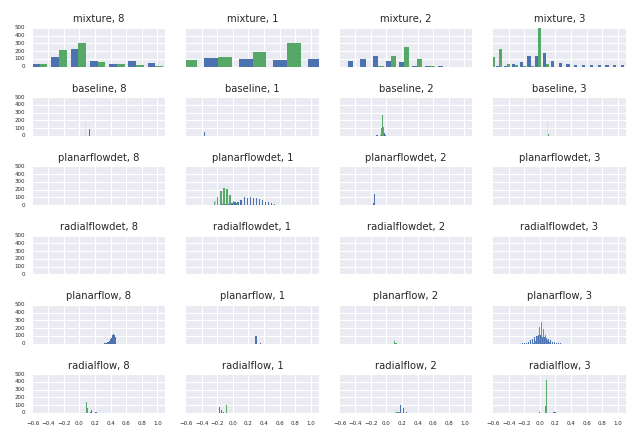

<IPython.core.display.Javascript object>


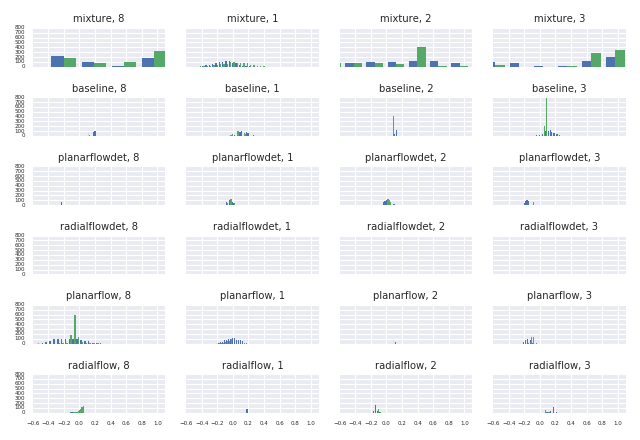

In [65]:
for i in range(n_best):
    fig, axs = plt.subplots(nrows=lp, ncols=lnn, sharex=True, sharey=True)

    axs_iter = axs.flat
    for test in best_hyper_samples:
        for name in best_hyper_samples[test]:
            for nn in best_hyper_samples[test][name]:
                if name == "baselinedet":
                    continue
                samples = best_hyper_samples[test][name][nn][i]
                ax = next(axs_iter)
                ax.hist(samples, bins="auto", edgecolor="none") #50
                ax.tick_params(axis='both', which='major', labelsize=5)
                ax.tick_params(axis='both', which='minor', labelsize=5)
        #         ax.set_ylabel("frequency")
        #         ax.set_xlabel("parameter")
                ax.set_title("%s, %i" % (name, nn), fontsize=9)
    plt.xlim([-0.6, 1.1])
    fig.tight_layout()

## number of modes / histogram of modes

In [66]:
nr_modes = eva.get_nr_modes(best_hyper_samples)
nr_modes

defaultdict(<function evaluation.defaultdictdict>,
            {'best_val_loss': defaultdict(dict,
                         {'baseline': {1: Counter({1: 4}),
                           2: Counter({1: 4}),
                           3: Counter({1: 4}),
                           8: Counter({1: 4})},
                          'mixture': {1: Counter({1: 2, 2: 2}),
                           2: Counter({1: 1, 2: 3}),
                           3: Counter({1: 1, 2: 3}),
                           8: Counter({3: 3, 4: 1})},
                          'planarflow': {1: Counter({1: 4}),
                           2: Counter({1: 4}),
                           3: Counter({1: 4}),
                           8: Counter({1: 4})},
                          'planarflowdet': {1: Counter({1: 4}),
                           2: Counter({1: 4}),
                           3: Counter({1: 4}),
                           8: Counter({1: 4})},
                          'radialflow': {1: Counter({1: 4}),
      

## Correlations between parameters

In [33]:
reload(eva)

<module 'evaluation' from '/home/stephan/GitProjects/theano_models/experiment/__file__'>

In [67]:
correlations = eva.get_best_correlations(best_hyper_samples)

defaultdict(<function evaluation.defaultdictdictlist>,
            {'best_val_loss': defaultdict(<function evaluation.defaultdictlist>,
                         {'baseline': defaultdict(list,
                                      {1: [array([[ 1.        ,  0.03459826],
                                               [ 0.03459826,  1.        ]]),
                                        array([[ 1.        ,  0.06427125],
                                               [ 0.06427125,  1.        ]])],
                                       2: [array([[ 1.       ,  0.0303323],
                                               [ 0.0303323,  1.       ]]),
                                        array([[ 1.        ,  0.03259817],
                                               [ 0.03259817,  1.        ]])],
                                       3: [array([[ 1.        , -0.00305581],
                                               [-0.00305581,  1.        ]]),
                                        a

In [68]:
for test in correlations:
    for name in correlations[test]:
        for nn in correlations[test][name]:
            correlations[test][name][nn] = np.array(map(lambda a:a[0,1], correlations[test][name][nn]))

<IPython.core.display.Javascript object>


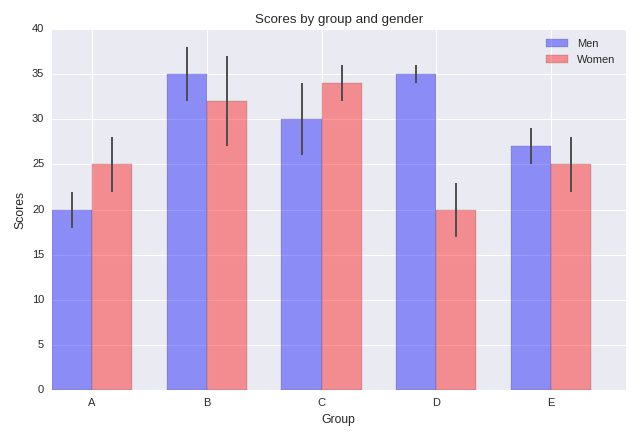

In [73]:
"""
Bar chart demo with pairs of bars grouped for easy comparison.
"""
import numpy as np
import matplotlib.pyplot as plt


n_groups = 5

means_men = (20, 35, 30, 35, 27)
std_men = (2, 3, 4, 1, 2)

means_women = (25, 32, 34, 20, 25)
std_women = (3, 5, 2, 3, 3)

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = plt.bar(index, means_men, bar_width,
                 alpha=opacity,
                 color='b',
                 yerr=std_men,
                 error_kw=error_config,
                 label='Men')

rects2 = plt.bar(index + bar_width, means_women, bar_width,
                 alpha=opacity,
                 color='r',
                 yerr=std_women,
                 error_kw=error_config,
                 label='Women')

plt.xlabel('Group')
plt.ylabel('Scores')
plt.title('Scores by group and gender')
plt.xticks(index + bar_width, ('A', 'B', 'C', 'D', 'E'))
plt.legend()

plt.tight_layout()

In [76]:
from itertools import count as icount

In [83]:
1/(len(n_normflows) +1)

0.2

<IPython.core.display.Javascript object>


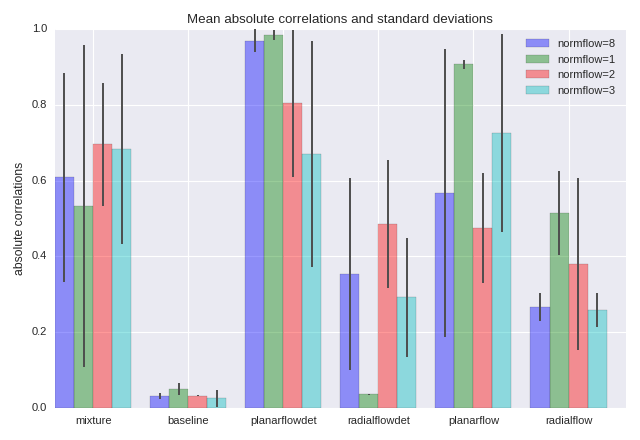

In [86]:
fig, ax = plt.subplots()

index = np.arange(len(model_prefixes))
bar_width = 1/(len(n_normflows) +1)

opacity = 0.4
error_config = {'ecolor': '0.3'}
colors = ["b","g","r","c","m","y","k","w"]


for test in correlations:
    for i, nn, c in zip(icount(), n_normflows, colors):
        means = [abs(correlations[test][name][nn]).mean() for name in model_prefixes]
        stds = [abs(correlations[test][name][nn]).std() for name in model_prefixes]
        rect = plt.bar(index + i*bar_width, means, bar_width,
                     alpha=opacity,
                     color=c,
                     yerr=stds,
                     error_kw=error_config,
                     label='normflow=%i' % nn)

#     plt.xlabel('Group')
    plt.ylabel('absolute correlations')
    plt.title('Mean absolute correlations and standard deviations')
    plt.xticks(index + bar_width*(len(n_normflows)//2), model_prefixes)
    plt.legend()
    plt.tight_layout()

## KL divergence

This must be computed on histograms, as we need an approximation for the densities/pms

In [93]:
reload(eva)

<module 'evaluation' from '/home/stephan/GitProjects/theano_models/experiment/__file__'>

In [94]:
best_kl = eva.compute_kl(best_hyper_samples)

<IPython.core.display.Javascript object>


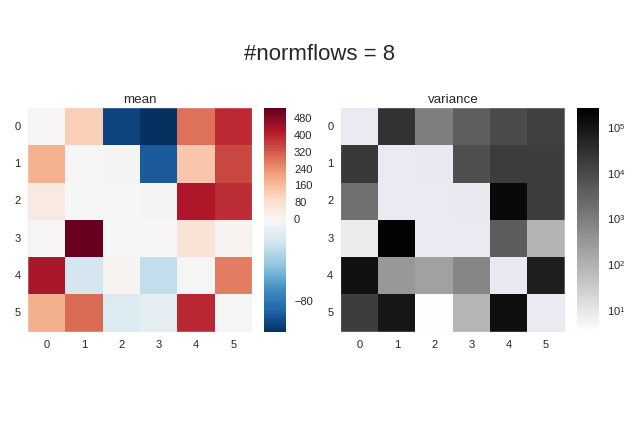

<IPython.core.display.Javascript object>


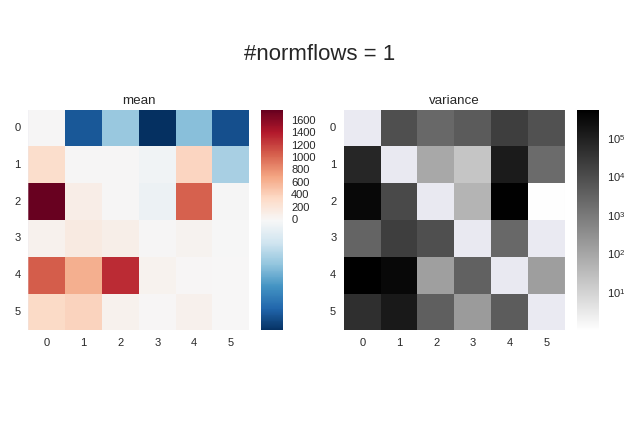

<IPython.core.display.Javascript object>


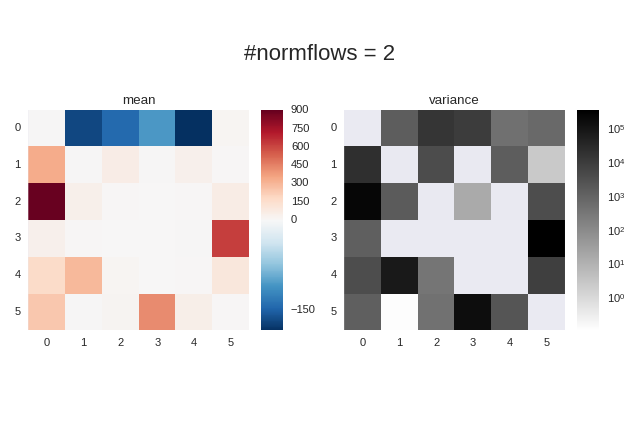

<IPython.core.display.Javascript object>


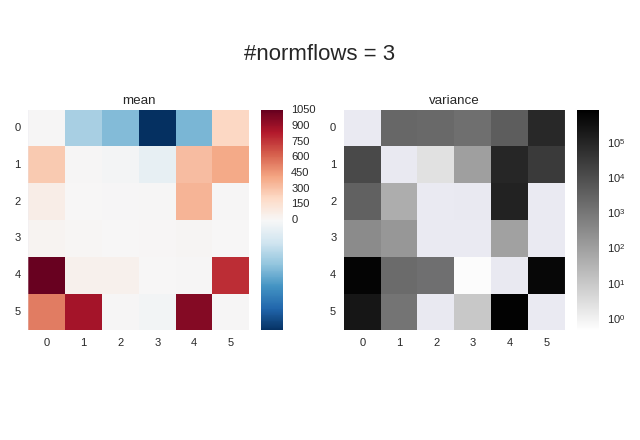

In [123]:
def add_colorbar(ax, h):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="10%", pad=0.15)
    cbar = plt.colorbar(h, cax=cax)
    
for nn in n_normflows:
    means = np.mean(best_kl['best_val_loss'][nn], axis=0)
    variances = np.var(best_kl['best_val_loss'][nn], axis=0)

    fig, axs = plt.subplots(ncols=2)
    h = axs[0].imshow(means, interpolation="None", cmap=plt.cm.RdBu_r, norm=Centre(0))
    axs[0].set_title("mean")
    add_colorbar(axs[0], h)

    h = axs[1].imshow(variances, interpolation="None", cmap=plt.cm.gray_r, norm=LogNorm())
    axs[1].set_title("variance")
    add_colorbar(axs[1], h)
    for ax in axs:
        ax.grid(False)
    fig.suptitle("#normflows = %i" %nn, fontsize=20, y=0.90)
    fig.tight_layout()
    # Make space for title
#     plt.subplots_adjust(top=0.85)